## Preprocesses

### 0.1 Seperate Reference from Answer in parquet dataset

In [ ]:
import pandas as pd
import re

ds_calm = pd.read_parquet('./data/rag-test-dataset-calm-adrd.parquet')

ds_calm['References'] = ""
ds_calm['Generation'] = ""

for idx, row in ds_calm.iterrows():
    answer = row['Answer']
    
    pure_answer = answer
    references_list = []
    
    if "References" in answer:
        # Split the answer into pure answer and references section
        pure_answer, references_section = answer.split("References", 1)
        
        pure_answer = pure_answer.strip()
        
        
        # Split the references section into a list of references
        references_section = "References" + references_section.strip()

        references_list = []
        
        reference_matches = re.findall(r'\[\d+\]\s*(.*?)(?=\[\d+\]|\Z)', references_section, re.DOTALL)
        
        for ref in reference_matches:
            ref = ref.strip()
            if ref:
                references_list.append(ref)
            
    # Use regex to remove [number] citations from pure answer
    pure_answer = re.sub(r'\[\d+\]', '', pure_answer).strip()
    
    ds_calm.at[idx, 'Generation'] = pure_answer
    ds_calm.at[idx, 'References'] = references_list
    
    
    
    print(f"Answers: {pure_answer}")

ds_calm.to_parquet('./data/rag-test-dataset-calm-adrd.parquet')

## Step 1 : Get answer from CaLM AI, GPT

>intermediate model: `qwen2.5:coder-7b`,
>generation model: `phi4:latest-14b`

So during the next following blocks, we will add CaLM AI result into the dataframe.

1. Test the API call, make sure it works whenever we trying to update the frame.

2. Loop question, and calll the API and add the result into the dataframe.

3. After the result is added, we will display the updated dataframe and save it as a parquet file.

In [ ]:
import pandas as pd

ds_calm = pd.read_parquet('./data/rag-test-dataset-calm-adrd.parquet')

ds_calm.describe()

In [ ]:
# Test the API call

from API import call_calm

calm_ans = call_calm("my mom seems forgetting thinks, what should I do ?")
print(type(calm_ans))
print(calm_ans)

In [ ]:
# Add answer to gpt-4o column
import time
from API import call_openai

for idx, row in ds_calm.iterrows():
    question = row['Question']
    print(f"Processing question {idx+1}/{len(ds_calm)}: {question[:50]}...")
    
    try:
        answer = call_openai(model="gpt-4o", question=question)
        ds_calm.at[idx, 'gpt-4o'] = answer.content
        
    except Exception as e:
        print(f"✗ Error processing question {idx+1}: {str(e)}")
        ds_calm.at[idx, 'gpt-4o'] = f"Error: {str(e)}"
        
        time.sleep(1)

# Display the updated dataframe with CALM ADRD answers
ds_calm.head()

ds_calm.to_parquet("./data/rag-test-dataset-calm-adrd.parquet")

## Step 2

Now, answer from `CaLM-ADRD` is ready, we are calculating the model

In [2]:
import pandas as pd

ds_calm = pd.read_parquet('./data/rag-test-dataset-calm-adrd.parquet')

ds_calm.head()

,Question,Context,Answer,calm-adrd,gpt-4o-mini,gpt-4o,References,Generation
0,Can you recommend activities that are suitable...,Content: What are some tips for Finding Activi...,When looking for activities for someone with d...,I understand that finding suitable activities ...,Absolutely! Engaging individuals with dementia...,Engaging activities for individuals with demen...,[https://www.agingcare.com/articles/my-elderly...,When looking for activities for someone with d...
1,What are the benefits of hospice care for indi...,Content: How to be an effective caregiver in t...,Hospice care offers several benefits for indiv...,I understand that navigating the advanced stag...,Hospice care can provide numerous benefits for...,Hospice care can provide numerous benefits for...,[https://www.caregiver.org/resource/alzheimers...,Hospice care offers several benefits for indiv...
2,How can I navigate difficult family dynamics w...,Content: How to Handle Seemingly Manipulative ...,When navigating difficult family dynamics whil...,Navigating difficult family dynamics while car...,Caring for a loved one with Alzheimer's can be...,Navigating difficult family dynamics while car...,[https://www.agingcare.com/articles/dementia-b...,When navigating difficult family dynamics whil...
3,What are the early signs of dementia?,Content: None The early warning signs of demen...,The early signs of dementia can vary from pers...,I understand that learning about the early sig...,"Early signs of dementia can vary, but here are...",Early signs of dementia can vary between indiv...,[https://www.agingcare.com/articles/alzheimers...,The early signs of dementia can vary from pers...
4,"How does palliative care differ from hospice, ...",Content: What end-of-life care options are ava...,Palliative care and hospice care are both form...,I understand that navigating care options for ...,Palliative care and hospice care are both appr...,Palliative care and hospice care are both appr...,[https://www.agingcare.com/articles/end-stage-...,Palliative care and hospice care are both form...


### 2.1 BLEU Score

In [3]:
# Calculate BLEU score

from tools.calculators import calculate_bleu_score

calm_scores = []
gpt_scores = []

for index, row in ds_calm.iterrows():
    calm_pred = row.get('calm-adrd')
    gpt_pred = row.get('gpt-4o')
    ref = row.get('Generation')
    
    calm_bleu_score = calculate_bleu_score([calm_pred], [ref])
    gpt_bleu_score = calculate_bleu_score([gpt_pred], [ref])
    
    calm_scores.append(calm_bleu_score['bleu'])
    gpt_scores.append(gpt_bleu_score['bleu'])
    
    print(f"CaLM BLEU Score: {calm_bleu_score['bleu']:.4f}, GPT BLEU Score: {gpt_bleu_score['bleu']:.4f}")


/Users/drakezhou/Development-Projects/rag-evaluation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CaLM BLEU Score: 0.0320, GPT BLEU Score: 0.0376
CaLM BLEU Score: 0.0754, GPT BLEU Score: 0.0869
CaLM BLEU Score: 0.0680, GPT BLEU Score: 0.0504
CaLM BLEU Score: 0.0640, GPT BLEU Score: 0.0193
CaLM BLEU Score: 0.1506, GPT BLEU Score: 0.1593
CaLM BLEU Score: 0.0823, GPT BLEU Score: 0.0419
CaLM BLEU Score: 0.0753, GPT BLEU Score: 0.0399
CaLM BLEU Score: 0.0439, GPT BLEU Score: 0.1041
CaLM BLEU Score: 0.0000, GPT BLEU Score: 0.0559
CaLM BLEU Score: 0.1278, GPT BLEU Score: 0.0555
CaLM BLEU Score: 0.1016, GPT BLEU Score: 0.0668
CaLM BLEU Score: 0.0899, GPT BLEU Score: 0.1302
CaLM BLEU Score: 0.1024, GPT BLEU Score: 0.1110
CaLM BLEU Score: 0.0660, GPT BLEU Score: 0.0741
CaLM BLEU Score: 0.0870, GPT BLEU Score: 0.0593
CaLM BLEU Score: 0.1156, GPT BLEU Score: 0.0590
CaLM BLEU Score: 0.1014, GPT BLEU Score: 0.0748
CaLM BLEU Score: 0.0594, GPT BLEU Score: 0.1007
CaLM BLEU Score: 0.0355, GPT BLEU Score: 0.0415
CaLM BLEU Score: 0.1746, GPT BLEU Score: 0.0763
CaLM BLEU Score: 0.2212, GPT BLEU Score:

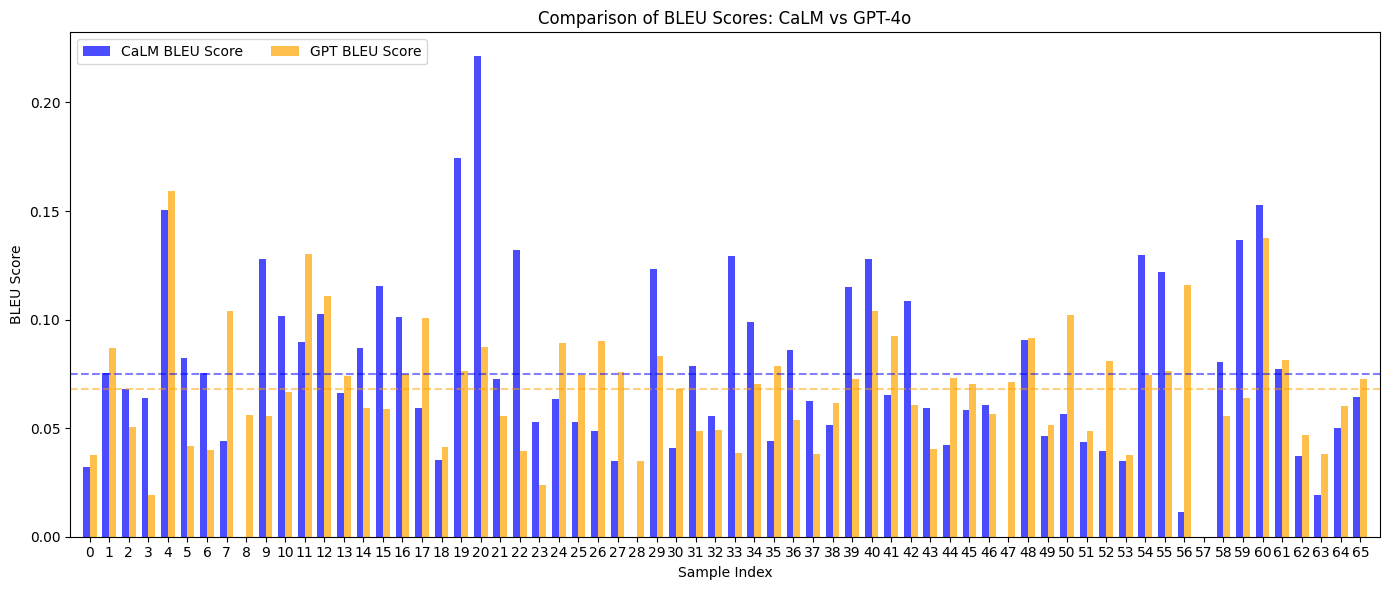

CaLM BLEU Average Score: 0.0747
GPT BLEU Average Score: 0.0679


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# matplotlib.style.use('./style/apa.mplstyle')
# plt.style.use('./style/apa.mplstyle')


plt.figure(figsize=(14, 6))

# Create indices
indices = np.arange(len(calm_scores))
bar_width = 0.35

# Create chart
bar1 = plt.bar(indices, calm_scores, bar_width, label='CaLM BLEU Score', alpha=0.7, color='blue')
bar2 = plt.bar(indices + bar_width, gpt_scores, bar_width, label='GPT BLEU Score', alpha=0.7, color='orange')


# Add labels and title
plt.xlabel('Sample Index')
plt.ylabel('BLEU Score')
plt.title('Comparison of BLEU Scores: CaLM vs GPT-4o')
plt.xticks(indices + bar_width / 2, indices)
plt.legend(loc='upper left', ncol=2)

# Calculate average scores
calm_avg = np.mean(calm_scores)
gpt_avg = np.mean(gpt_scores)

# Add average score lines to the chart
plt.axhline(y=calm_avg, color='blue', linestyle='--', alpha=0.5, label=f'CaLM Average: {calm_avg:.4f}')
plt.axhline(y=gpt_avg, color='orange', linestyle='--', alpha=0.5, label=f'GPT Average: {gpt_avg:.4f}')

# Display chart
plt.tight_layout()
plt.margins(x=0.01)
plt.show()

# Print average scores
print(f"CaLM BLEU Average Score: {calm_avg:.4f}")
print(f"GPT BLEU Average Score: {gpt_avg:.4f}")

### 2.2 ROUGE Evaluation:

ROUGE-1: Measures the overlap of unigrams (single words) between the system and reference summaries.

ROUGE-2: Measures the overlap of bigrams (two consecutive words) between the system and reference summaries.
 
ROUGE-L: Measures the longest common subsequence (LCS) between the system and reference summaries. This metric is more flexible as it allows for gaps in the matching sequences, capturing longer phrase matches even if they are not consecutive.


In [ ]:
from tools.calculators import calculate_rouge_scores


calm_rouge_1 = []
calm_rouge_2 = []
calm_rouge_l = []

gpt_rouge_1 = []
gpt_rouge_2 = []
gpt_rouge_3 = []
gpt_rouge_l = []

for idx, row in ds_calm.iterrows():
    question = row['Question']
    ref = row['Generation']
    calm_pred = row['calm-adrd']
    gpt_pred = row['gpt-4o']
    
    gr = calculate_rouge_scores([calm_pred], [ref])
    gr_gpt = calculate_rouge_scores([gpt_pred], [ref])
    
    calm_rouge_1.append(gr['rouge1'])
    calm_rouge_2.append(gr['rouge2'])
    calm_rouge_l.append(gr['rougeL'])
    
    gpt_rouge_1.append(gr_gpt['rouge1'])
    gpt_rouge_2.append(gr_gpt['rouge2'])
    gpt_rouge_l.append(gr_gpt['rougeL'])
    
    print(f"CaLM ROUGE-1: {gr['rouge1']:.4f}, GPT ROUGE-1: {gr_gpt['rouge1']:.4f}")
    print(f"CaLM ROUGE-2: {gr['rouge2']:.4f}, GPT ROUGE-2: {gr_gpt['rouge2']:.4f}")
    print(f"CaLM ROUGE-L: {gr['rougeL']:.4f}, GPT ROUGE-L: {gr_gpt['rougeL']:.4f}")

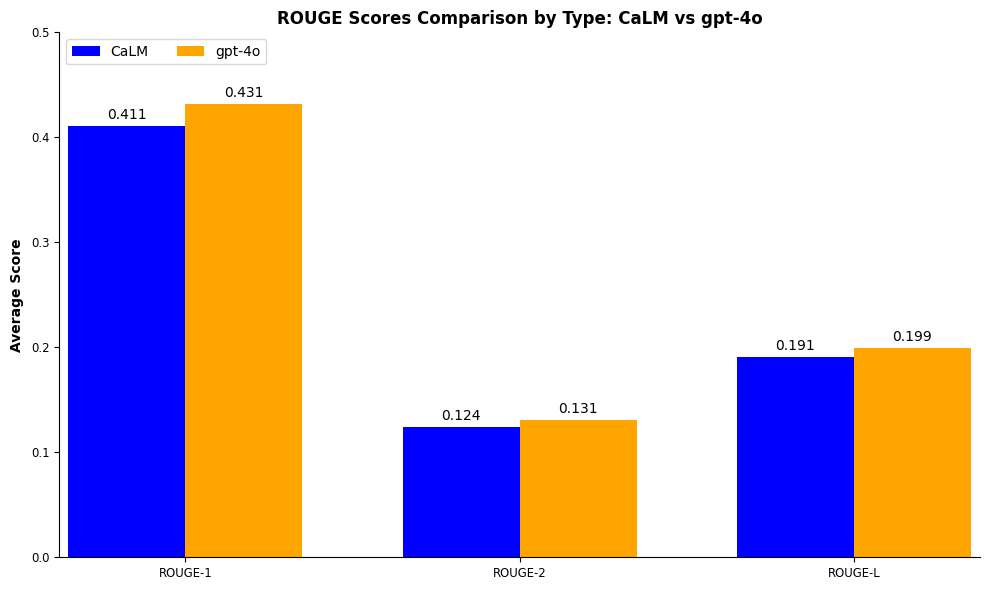

CaLM - ROUGE-1: 0.4110, ROUGE-2: 0.1239, ROUGE-L: 0.1909
gpt-4o - ROUGE-1: 0.4314, ROUGE-2: 0.1309, ROUGE-L: 0.1994


In [13]:

import matplotlib.pyplot as plt
import numpy as np

# Calculate average scores
calm_rouge_1_avg = np.mean(calm_rouge_1)
calm_rouge_2_avg = np.mean(calm_rouge_2)
calm_rouge_l_avg = np.mean(calm_rouge_l)

gpt_rouge_1_avg = np.mean(gpt_rouge_1)
gpt_rouge_2_avg = np.mean(gpt_rouge_2)
gpt_rouge_l_avg = np.mean(gpt_rouge_l)

rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
calm_scores = [calm_rouge_1_avg, calm_rouge_2_avg, calm_rouge_l_avg]
gpt_scores = [gpt_rouge_1_avg, gpt_rouge_2_avg, gpt_rouge_l_avg]

x = np.arange(len(rouge_types))
width = 0.35

plt.style.use('./style/apa.mplstyle')

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange']

rects1 = ax.bar(x - width/2, calm_scores, width, label='CaLM', color=colors[0])
rects2 = ax.bar(x + width/2, gpt_scores, width, label='gpt-4o', color=colors[1])

ax.set_ylabel('Average Score')
ax.set_title('ROUGE Scores Comparison by Type: CaLM vs gpt-4o')
ax.set_xticks(x)
ax.set_xticklabels(rouge_types)
ax.legend(loc='upper left', ncol=2)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3点垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

# ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.margins(x=0.01)
plt.show()

print(f"CaLM - ROUGE-1: {calm_rouge_1_avg:.4f}, ROUGE-2: {calm_rouge_2_avg:.4f}, ROUGE-L: {calm_rouge_l_avg:.4f}")
print(f"gpt-4o - ROUGE-1: {gpt_rouge_1_avg:.4f}, ROUGE-2: {gpt_rouge_2_avg:.4f}, ROUGE-L: {gpt_rouge_l_avg:.4f}")


### 2.3 Cosine Similarity

In [14]:
from tools.calculators import calculate_cosine_similarity

calm_sim_list = []
gpt_sim_list = []

for idx, row in ds_calm.iterrows():
    
    calm_answer = row["calm-adrd"]
    gpt_answer = row["gpt-4o"]
    reference = row["Generation"]
    
    calm_sim = calculate_cosine_similarity(calm_answer, reference)
    gpt_sim = calculate_cosine_similarity(gpt_answer, reference)
    
    calm_sim_list.append(calm_sim)
    gpt_sim_list.append(gpt_sim)

    print(f"Calm: {sum(calm_sim_list) / len(calm_sim_list)}, GPT: {sum(gpt_sim_list) / len(gpt_sim_list)}")

Calm: 0.8986390829086304, GPT: 0.9127194881439209
Calm: 0.9056364595890045, GPT: 0.9307278990745544
Calm: 0.8958350618680319, GPT: 0.9142732620239258
Calm: 0.8926552534103394, GPT: 0.9015922844409943
Calm: 0.8971501588821411, GPT: 0.9073569774627686
Calm: 0.8955996632575989, GPT: 0.9009816745917002
Calm: 0.9028761216572353, GPT: 0.9009169254984174
Calm: 0.8983976095914841, GPT: 0.9064465090632439
Calm: 0.8917962312698364, GPT: 0.9015917049513923
Calm: 0.8959442377090454, GPT: 0.9026192843914032
Calm: 0.8966811190951954, GPT: 0.9036787098104303
Calm: 0.8974959701299667, GPT: 0.9051367441813151
Calm: 0.8912184834480286, GPT: 0.9091308208612295
Calm: 0.8920550559248243, GPT: 0.9109708113329751
Calm: 0.893822173277537, GPT: 0.9133952895800272
Calm: 0.8950461260974407, GPT: 0.913800161331892
Calm: 0.8924563386861015, GPT: 0.914261519908905
Calm: 0.8910436199771034, GPT: 0.9130016797118716
Calm: 0.8908429051700392, GPT: 0.9124318894587065
Calm: 0.8927313625812531, GPT: 0.9137359768152237
Cal

/var/folders/_l/b0gq7jr123bdg2xl0t5zgn3c0000gn/T/ipykernel_91247/1346253765.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([calm_sim_list, gpt_sim_list], labels=['Calm', 'GPT-4'])
/var/folders/_l/b0gq7jr123bdg2xl0t5zgn3c0000gn/T/ipykernel_91247/1346253765.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', ncol=2)


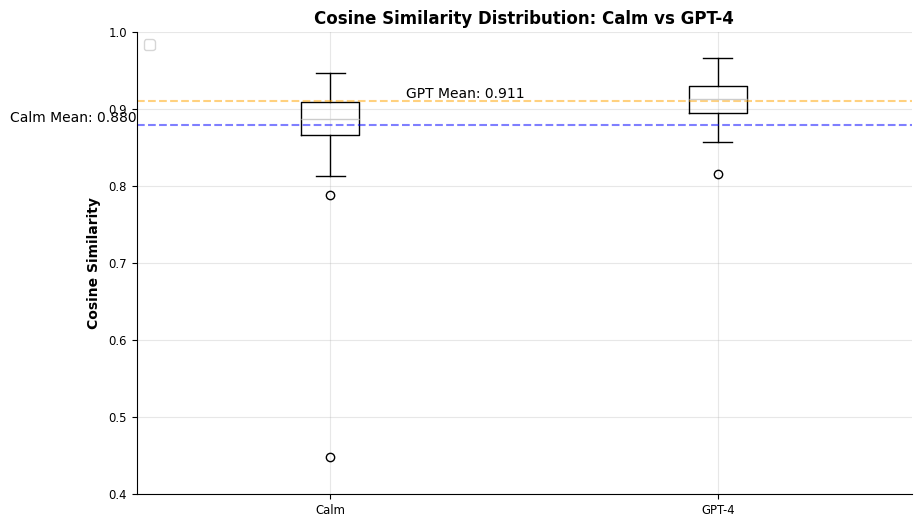

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate means using numpy
calm_mean = np.mean(calm_sim_list)
gpt_mean = np.mean(gpt_sim_list)

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots
ax.boxplot([calm_sim_list, gpt_sim_list], labels=['Calm', 'GPT-4'])

# Add mean lines
ax.axhline(y=calm_mean, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=gpt_mean, color='orange', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('Cosine Similarity Distribution: Calm vs GPT-4')
ax.set_ylabel('Cosine Similarity')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', ncol=2)

# Add mean values as text
ax.text(0.5, calm_mean, f'Calm Mean: {calm_mean:.3f}', 
         verticalalignment='bottom', horizontalalignment='right')
ax.text(1.5, gpt_mean, f'GPT Mean: {gpt_mean:.3f}', 
         verticalalignment='bottom', horizontalalignment='right')

plt.margins(x=0.01)
plt.show()
    
    

### 2.4 CHAR F

In [22]:
from tools.calculators import calculate_char_f_score
from IPython import display

calm_chrf_list = []
gpt_chrf_list = []

try:
    for idx, row in ds_calm.iterrows():
        question = row['Question']
        ref = row['Generation']
        calm_pred = row['calm-adrd']
        gpt_pred = row['gpt-4o']
        
        gr = calculate_char_f_score([calm_pred], [ref])
        gr_gpt = calculate_char_f_score([gpt_pred], [ref])
        
        calm_chrf_list.append(gr['score'])
        gpt_chrf_list.append(gr_gpt['score'])
        
        print(f"Calm: {sum(calm_chrf_list) / len(calm_chrf_list)}, GPT: {sum(gpt_chrf_list) / len(gpt_chrf_list)}")
        
    display.clear_output(wait=True)
    print("CHAR F Score Calculation Complete")
except Exception as e:
    print(f"Error: {e}")

CHAR F Score Calculation Complete


/var/folders/_l/b0gq7jr123bdg2xl0t5zgn3c0000gn/T/ipykernel_91247/2781449354.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', ncol=2)


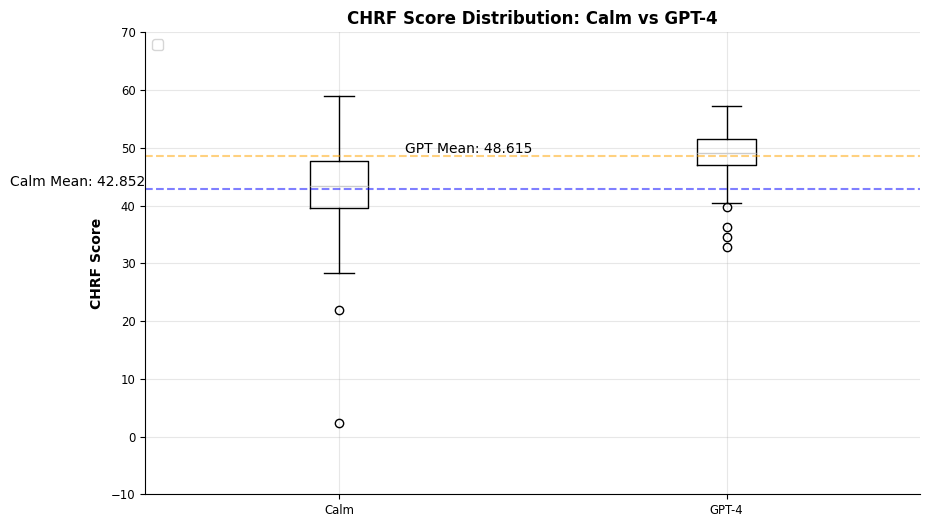

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create visualization for CHRF scores
calm_mean_chrf = sum(calm_chrf_list) / len(calm_chrf_list)
gpt_mean_chrf = sum(gpt_chrf_list) / len(gpt_chrf_list)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot box plots
ax.boxplot([calm_chrf_list, gpt_chrf_list], tick_labels=['Calm', 'GPT-4'])

# Add mean lines
ax.axhline(y=calm_mean_chrf, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=gpt_mean_chrf, color='orange', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_title('CHRF Score Distribution: Calm vs GPT-4')
ax.set_ylabel('CHRF Score')
ax.grid(True, alpha=0.3)

# Add mean values as text
ax.text(0.5, calm_mean_chrf, f'Calm Mean: {calm_mean_chrf:.3f}', 
        verticalalignment='bottom', horizontalalignment='right')
ax.text(1.5, gpt_mean_chrf, f'GPT Mean: {gpt_mean_chrf:.3f}', 
        verticalalignment='bottom', horizontalalignment='right')

plt.show()


### 2.5 BERT Score

In [2]:
from tools.calculators import calculate_bert_score
from IPython import display

calm_bert_list = []
gpt_bert_list = []

try:
    for idx, row in ds_calm.iterrows():
        calm_pred = row['calm-adrd']
        gpt_pred = row['gpt-4o']
        ref = row['Generation']
        
        cr = calculate_bert_score([calm_pred], [ref])
        gr = calculate_bert_score([gpt_pred], [ref])
        
        calm_bert_list.append(cr['f1'])
        gpt_bert_list.append(gr['f1'])
        
        print(f"Nub.{idx} @ Calm: {cr['f1']}, GPT: {gr['f1']}")
        
    display.clear_output(wait=True)
    print("BERT Score Calculation Complete")
except Exception as e:
    print(f"Error: {e}")

BERT Score Calculation Complete


In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.close('all')
plt.style.use('./style/apa.mplstyle')


# 计算平均值
calm_mean_bert = np.mean(calm_bert_list)
gpt_mean_bert = np.mean(gpt_bert_list)


# 创建图形和轴
fig, ax = plt.subplots(figsize=(10, 6))

# 设置条形图的位置
x = np.array([1, 2])
width = 0.5

# 绘制条形图
bars = ax.bar(x, [calm_mean_bert, gpt_mean_bert], width, color=['blue', 'orange'])

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom')

# 设置图表标题和标签
ax.set_title('BERT Score CaLM vs GPT-4o', fontsize=15)
ax.set_ylabel('BERT Score (F1)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(['CaLM ADRD', 'GPT-4o'])
ax.set_ylim(0, max(calm_mean_bert, gpt_mean_bert) * 1.1)  # 设置y轴范围，留出空间显示数值

# 添加网格线使图表更易读
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# # 将BERT Score结果保存到CSV文件中
# import pandas as pd

# # 创建包含两个列表的数据框
# bert_scores_df = pd.DataFrame({
#     'Calm_BERT_Score': calm_bert_list,
#     'GPT4o_BERT_Score': gpt_bert_list
# })

# # 保存到CSV文件
# csv_filename = './data/scores_comparison.csv'
# bert_scores_df.to_csv(csv_filename, index=True, index_label='Question_Index')

# print(f"BERT Scores已保存到 {csv_filename}")



NameError: name 'calm_bert_list' is not defined